### Step 1: Import Required Libraries

## Library Imports & Their Purpose
###  `pandas`
- **Library:** `pandas as pd`
- **Purpose:** For data loading, manipulation, filtering, and aggregation.
- **Use Case:** Reading Excel files, handling missing values, calculating Recency, Frequency, and Monetary values.

### `numpy`
- **Library:** `numpy as np`
- **Purpose:** Fundamental package for numerical computations and working with arrays.
- **Use Case:** Mathematical operations, transformations, and handling numerical data.

###  `matplotlib.pyplot`
- **Library:** `matplotlib.pyplot as plt`
- **Purpose:** Plotting graphs and visualizations.
- **Use Case:** Line plots (Elbow Method), dendrograms, 3D PCA plots.

###  `seaborn`
- **Library:** `seaborn as sns`
- **Purpose:** Statistical data visualization based on matplotlib.
- **Use Case:** Creating scatter plots for visualizing clusters with better styling.

---

###  `sklearn.preprocessing.StandardScaler`
- **Purpose:** Normalize features by removing the mean and scaling to unit variance.
- **Use Case:** Scaling Recency, Frequency, and Monetary values before clustering.

### `sklearn.cluster.KMeans` and `AgglomerativeClustering`
- **Purpose:** Machine learning models for unsupervised clustering.
- **Use Case:**
  - `KMeans`: Partition customers into `k` groups using centroids.
  - `AgglomerativeClustering`: Hierarchical clustering using linkage distance.

###  `sklearn.decomposition.PCA`
- **Purpose:** Principal Component Analysis for dimensionality reduction.
- **Use Case:** Reducing data to 3D to visualize clusters effectively.

###  `sklearn.metrics.silhouette_score`
- **Purpose:** Evaluate clustering quality.
- **Use Case:** Determine how well-separated the clusters are.

---

###  `scipy.cluster.hierarchy.dendrogram`, `linkage`
- **Purpose:** Hierarchical clustering visualizations.
- **Use Case:** Plotting dendrograms to decide optimal clusters for agglomerative clustering.



In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage


### Step 2: Load Dataset

In [7]:
file_path = 'Online Retail.xlsx'
df = pd.read_excel(file_path)

### Step 3: Basic Data Exploration
Understand the structure and check for missing values.


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [9]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


### Step 4: Data Cleaning
- Remove canceled transactions (InvoiceNo starts with 'C')
- Filter rows with valid CustomerID
- Convert `InvoiceDate` to datetime
- Create `TotalSpend` column


In [10]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
df = df[df['CustomerID'].notnull()]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalSpend'] = df['Quantity'] * df['UnitPrice']


<ipython-input-10-650e2d13f186>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
<ipython-input-10-650e2d13f186>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalSpend'] = df['Quantity'] * df['UnitPrice']


### Step 5: RFM Feature Engineering

In this step, we generate three critical behavioral metrics for each customer to prepare data for segmentation:

#### Recency
- **Definition**: Number of days since the customer's last purchase.
- **Calculation**: Subtract the customer's most recent invoice date from the latest invoice date in the dataset.
- **Interpretation**: Lower values indicate more recent activity.

#### Frequency
- **Definition**: Total number of transactions (invoices) per customer.
- **Calculation**: Count of invoices per `CustomerID`.
- **Interpretation**: Higher frequency indicates a loyal or returning customer.

#### Monetary
- **Definition**: Total money spent by the customer.
- **Calculation**: Sum of `TotalSpend` per customer.
- **Interpretation**: Higher values indicate more valuable customers in terms of revenue.



In [11]:
max_date = df['InvoiceDate'].max()
df['Recency'] = (max_date - df['InvoiceDate']).dt.days
frequency = df.groupby('CustomerID').size()
monetary = df.groupby('CustomerID')['TotalSpend'].sum()
# Combine R, F, M into a single DataFrame
customer_data = pd.DataFrame({
    'Recency': df.groupby('CustomerID')['Recency'].min(),
    'Frequency': frequency,
    'Monetary': monetary
}).reset_index()


### Step 6: Handling Missing Values

To ensure clustering works without errors, we check and handle any missing values in our `customer_data`.

- Here, we fill all `NaN` values with `0`.
- This is especially useful if any customer had missing monetary or frequency due to edge cases.


In [12]:
# Handle Missing Values
customer_data.fillna(0, inplace=True)


### Step 7: Feature Scaling (Standardization)

Before applying clustering algorithms, it's essential to normalize the data.

- **Why?** Clustering algorithms like K-Means are distance-based and sensitive to feature scales.
- **How?** We use `StandardScaler` from scikit-learn to standardize:
  - **Mean = 0**
  - **Standard Deviation = 1**

We scale only the numeric features: **Recency**, **Frequency**, and **Monetary**.


In [13]:
# Step 7: Normalize the features using StandardScaler
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[['Recency', 'Frequency', 'Monetary']])

# Convert back to DataFrame for readability
customer_data_scaled_df = pd.DataFrame(customer_data_scaled, columns=['Recency', 'Frequency', 'Monetary'])


### 📈 Step 8: K-Means Clustering — Elbow Method

To decide the optimal number of clusters (K) for K-Means, we use the **Elbow Method**.

#### What is WCSS?
- WCSS = Within-Cluster Sum of Squares.
- It measures how close data points in a cluster are to the centroid.

#### Elbow Method Steps:
1. Run K-Means clustering for a range of K values (1 to 10).
2. Store the WCSS for each value.
3. Plot K vs WCSS.

#### Interpretation:
- Look for the "elbow point" — the value of K where the WCSS stops decreasing significantly.
- This suggests the optimal number of clusters.


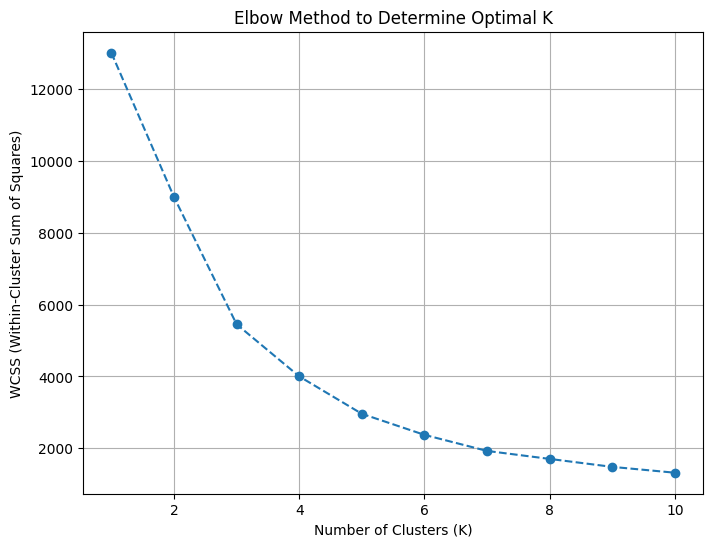

In [14]:
# Elbow Method to find the optimal number of clusters
wcss = []

for i in range(1, 11):
    kmeans = KMeans(
        n_clusters=i,
        init='k-means++',
        max_iter=300,
        n_init=10,
        random_state=42
    )
    kmeans.fit(customer_data_scaled_df)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method to Determine Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()


###  Step 9: Fit K-Means Model with Optimal K

We now apply K-Means clustering using the optimal number of clusters chosen from the elbow plot (e.g., **K=4**).

- The result is stored in a new column: **KMeans Cluster**.
- Each customer is now assigned to a cluster (0, 1, 2, or 3).


In [15]:
# K-Means model with the chosen number of clusters (e.g., 4)
kmeans = KMeans(
    n_clusters=4,
    init='k-means++',
    max_iter=300,
    n_init=10,
    random_state=42
)
customer_data['KMeans Cluster'] = kmeans.fit_predict(customer_data_scaled_df)


### Step 10: Visualizing K-Means Clusters

We use a scatter plot to visualize how customers are grouped:

- **X-axis**: Recency (how recently they purchased).
- **Y-axis**: Frequency (how often they purchase).
- **Color**: Assigned cluster from K-Means.

This helps in understanding cluster separation and identifying different customer segments (e.g., loyal, inactive, big spenders).


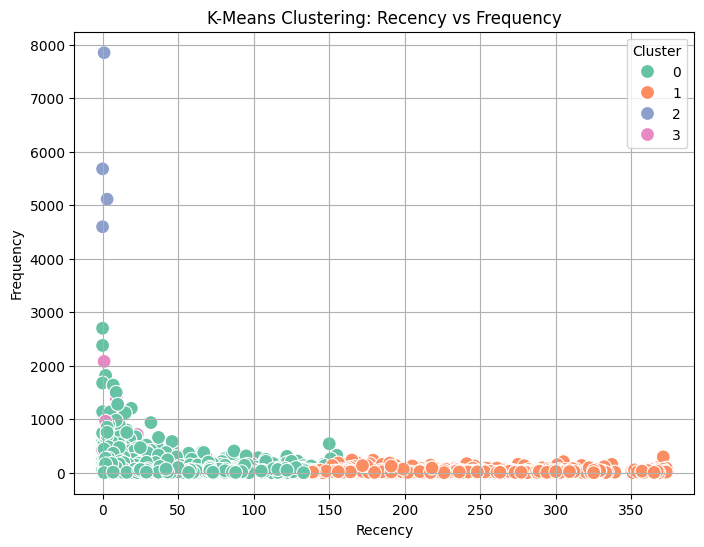

In [16]:
# Visualizing K-Means Clusters using Recency vs Frequency
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='Recency',
    y='Frequency',
    hue='KMeans Cluster',
    data=customer_data,
    palette='Set2',
    s=100
)
plt.title('K-Means Clustering: Recency vs Frequency')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


### Step 11: Dendrogram for Agglomerative (Hierarchical) Clustering

We use **Agglomerative Clustering**, a bottom-up hierarchical clustering method.

####  What’s Happening?
- Each point starts in its own cluster.
- The algorithm merges the closest pairs of clusters step-by-step.

#### Dendrogram:
- A tree-like plot showing how clusters are merged.
- The **height** at which two points are joined indicates the **distance** (dissimilarity).

#### Interpretation:
- Cut the dendrogram at the longest vertical distance without crossing horizontal lines to determine the optimal number of clusters (e.g., 4).


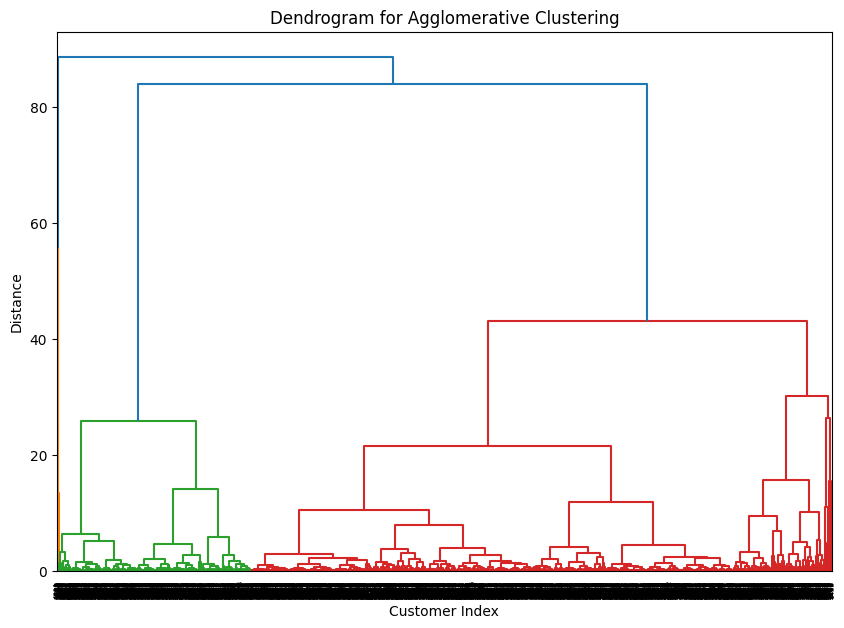

In [20]:
linked = linkage(customer_data_scaled_df, method='ward')

# Plot the dendrogram for Agglomerative Clustering
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Customer Index')
plt.ylabel('Distance')
plt.savefig('dendrogram_plot.png')  # Save the plot for the report
plt.show()


### Step 12: Fit Agglomerative Clustering Model

Using **Agglomerative Clustering**, we group customers into 4 clusters.

- `affinity='euclidean'`: Distance metric.
- `linkage='ward'`: Minimizes variance within each cluster.

The result is stored in the `Agglomerative Cluster` column for each customer.


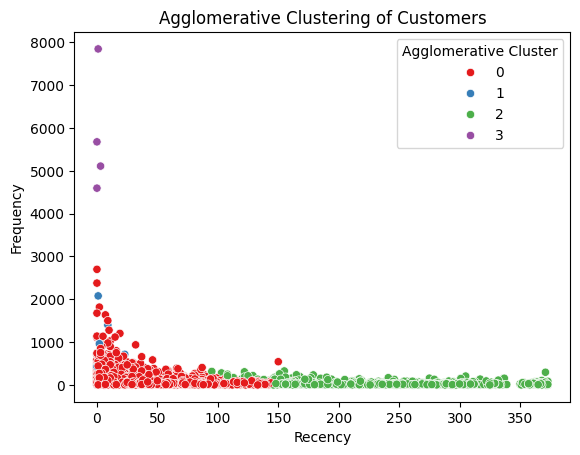

In [21]:
agg_clust = AgglomerativeClustering(n_clusters=4, linkage='ward')
customer_data['Agglomerative Cluster'] = agg_clust.fit_predict(customer_data_scaled_df)
# Plot Agglomerative Clusters
sns.scatterplot(x=customer_data['Recency'], y=customer_data['Frequency'], hue=customer_data['Agglomerative Cluster'], palette='Set1')
plt.title('Agglomerative Clustering of Customers')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()

### Step 13: Visualizing Agglomerative Clusters

This plot helps visualize how customers were grouped using hierarchical clustering.

- **X-axis**: Recency
- **Y-axis**: Frequency
- **Color**: Cluster label from Agglomerative Clustering

Compare this plot with the K-Means version to see how clustering behavior differs across algorithms.


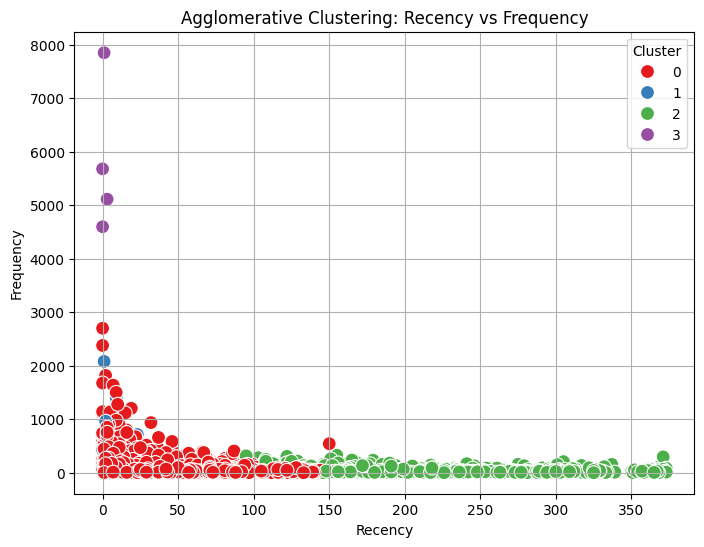

In [22]:
# Visualizing Agglomerative Clustering results
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='Recency',
    y='Frequency',
    hue='Agglomerative Cluster',
    data=customer_data,
    palette='Set1',
    s=100
)
plt.title('Agglomerative Clustering: Recency vs Frequency')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


### Step 14: PCA for 3D Visualization of K-Means Clusters

We reduce the dataset's dimensionality to 3 components using **PCA** (Principal Component Analysis) to visualize the clustering results in 3D.

- **PCA** is a technique that reduces the data from multiple dimensions to a smaller number, preserving as much of the variance as possible.
- This allows us to plot the clusters in 3D space and visually assess how well the K-Means algorithm performed.

In the plot:
- **X-axis**: Principal Component 1
- **Y-axis**: Principal Component 2
- **Z-axis**: Principal Component 3
- **Color**: Represents the different clusters assigned by K-Means.


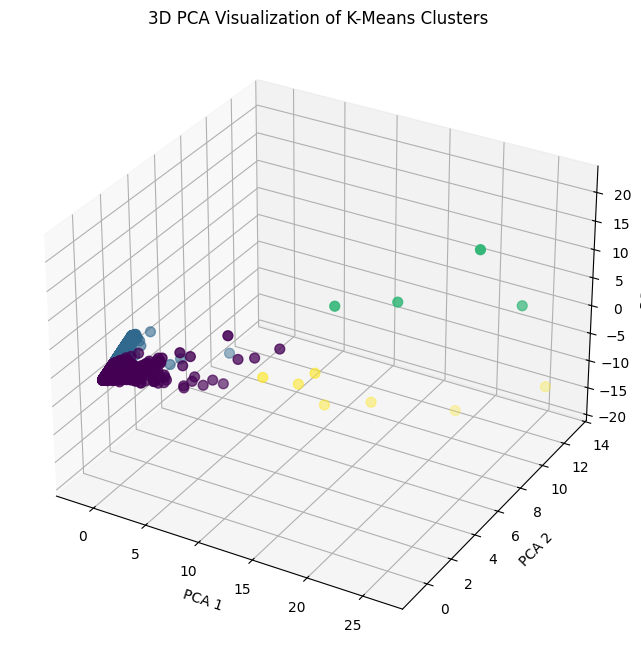

In [23]:
# Performing PCA for 3D visualization of the clusters
from sklearn.decomposition import PCA

# Applying PCA to reduce dimensions to 3
pca = PCA(n_components=3)
customer_data_pca = pca.fit_transform(customer_data_scaled_df)

# Creating a 3D scatter plot for K-Means clusters
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with K-Means cluster labels
ax.scatter(customer_data_pca[:, 0], customer_data_pca[:, 1], customer_data_pca[:, 2], c=customer_data['KMeans Cluster'], cmap='viridis', s=50)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

plt.title('3D PCA Visualization of K-Means Clusters')
plt.show()


### Step 15: Evaluating Clustering with Silhouette Score

The **Silhouette Score** is used to evaluate how well-defined the clusters are. It measures both:
- **Cohesion**: How close points in the same cluster are.
- **Separation**: How distinct a cluster is from others.

The score ranges from:
- **+1**: Perfect clustering.
- **0**: Clusters are overlapping.
- **-1**: Misclassified points.

We calculate the Silhouette Score for both **K-Means** and **Agglomerative Clustering** to assess their quality.


In [24]:
# Silhouette Score to evaluate clustering performance
from sklearn.metrics import silhouette_score
# K-Means Silhouette Score
kmeans_silhouette = silhouette_score(customer_data_scaled_df, customer_data['KMeans Cluster'])
print(f"K-Means Silhouette Score: {kmeans_silhouette}")
# Agglomerative Clustering Silhouette Score
agg_clust_silhouette = silhouette_score(customer_data_scaled_df, customer_data['Agglomerative Cluster'])
print(f"Agglomerative Clustering Silhouette Score: {agg_clust_silhouette}")


K-Means Silhouette Score: 0.6011029731426462
Agglomerative Clustering Silhouette Score: 0.5955243403491235
